In [90]:
# Libraries
%matplotlib inline
import pandas as pd
import shapefile as shp
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd 
from geopandas.tools import sjoin # Requires build from github for correct version
from shapely import geometry
import numpy as np
import os
import pysal as ps
import random

DATA_DIR = 'data/'
FIGURE_DIR = 'plots/'

SHAPE_FILE = 'CENSUS2010TOWNS_SHP/CENSUS2010TOWNS_POLY.shp'
CHILD_CARE_DATA = 'data/child_care_data1.csv'
CHILD_LAT = 'Latitude'
CHILD_LONG = 'Longitude'
CENSUS_DATA = 'data/census_data.csv'
GEO_COL = 'COUSUBFP10'
POINT_PROJECTION = 4326 #Projection for lat/longs
GEOMETRY = 'geometry' # Column name for geometery data
# Default CRS assuming census tiger tracts with NAD83 projections, found from prior work
DEFAULT_CRS = {'datum': 'NAD83','k': 0.999975, 'lat_0': 36.66666666666666,'lon_0': -88.33333333333333,
 'no_defs': True,'proj': u'tmerc',u'units': u'us-ft',u'x_0': 300000, u'y_0': 0} 
    

age
count    8252.000000
mean       14.498061
std         8.102789
min         2.000000
25%         8.000000
50%        14.000000
75%        18.000000
max        36.000000
Name: age, dtype: float64 

Capacity
count    8258.000000
mean       23.396827
std        34.183666
min         0.000000
25%         6.000000
50%         8.000000
75%        24.000000
max       460.000000
Name: Capacity, dtype: float64 

eMailAddress
62.0 % of centers have logged an active eMailAddress 

MailingZipcode
14.0 % of centers have logged an active MailingZipcode 

FaxNumber
11.0 % of centers have logged an active FaxNumber 

ProviderPhone
100.0 % of centers have logged an active ProviderPhone 

Center Type

Family Child Care                        5844
Large Group and School Age Child Care    2399
Small Group and School Age Child Care      15
Name: ProgramType, dtype: int64 



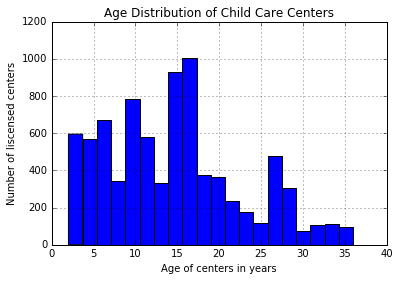

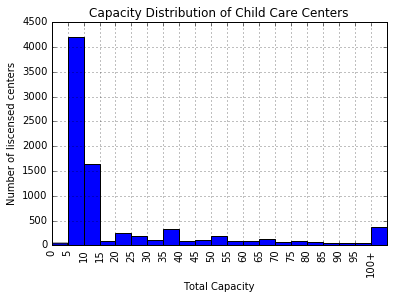

Island ids:  [117, 178]


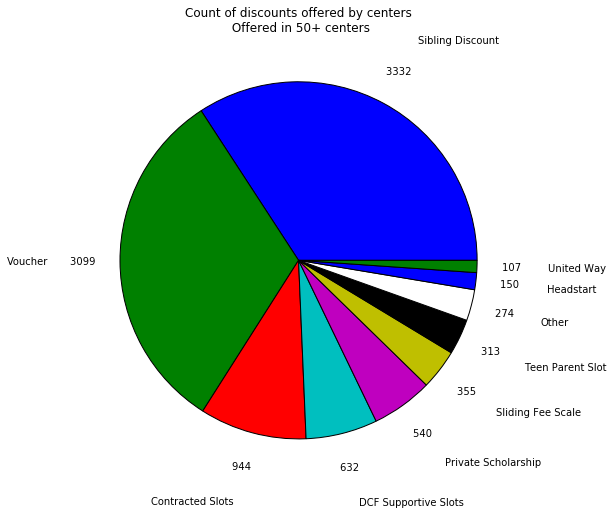

In [7]:
# Data Preparation

# Build data tied with geographic boundaries

shape_df = gpd.read_file(SHAPE_FILE)
if shape_df.crs == {}:
    shape_df = gpd.GeoDataFrame(shape_df,crs=DEFAULT_CRS)
    
shape_df[GEOMETRY] = shape_df[GEOMETRY].to_crs(epsg=POINT_PROJECTION)
shape_df = gpd.GeoDataFrame(shape_df,crs=None) #Remove crs so join completes

# Create dataframe with childcare information, remove points not in the area or null, join to town data
child_df = build_points(CHILD_CARE_DATA,CHILD_LAT,CHILD_LONG)

child_df = point_out_of_bounds(child_df,shape_df)
child_df = sjoin(child_df,shape_df,how='left')
# Get age from initial issue date
child_df['age'] = pd.to_datetime(child_df['FirstIssueDate']).apply(lambda x: pd.to_datetime('today').year - x.year) # convert age

# Run analysis across child care centers
child_care_analysis(child_df)

# Build town level data and join in relevant data from child care dataset
census_df = join_census_files()
town_data = pd.merge(census_df,shape_df,left_on=GEO_COL.lower(),right_on=GEO_COL)
town_data.index = town_data[GEO_COL]
town_data = clean_town_data(town_data, child_df)








In [146]:
def clean_town_data(town_data, child_df):

    center_cnt = child_df.groupby([GEO_COL]).count()['ProgramName'] # count of centers
    center_cap = child_df.groupby([GEO_COL]).sum()['Capacity'] # total capacity of centers
    town_data = town_data.join(center_cnt)
    town_data = town_data.join(center_cap)
    town_data.rename(columns={'ProgramName':'center_count'},inplace=True)

    # Set towns with no entries in child care data to 0 for capacity and program name
    town_data[['Capacity','center_count']] = town_data[['Capacity','center_count']].fillna(0)

    # Get nearby towns based on shared boundary
    get_nearby_town_info(town_data)
    add_age_categories(town_data)
    add_proportion_columns(town_data)
    
    return town_data
    
def add_proportion_columns(town_data):
    divide_cols = {'under_5':['total_age_under_5_years_age'],'5_to_9':['total_age_5_to_9_years_age'],
                   '10_to_14':['total_age_10_to_14_years_age'],
                   'under_10':['total_age_under_5_years_age','total_age_5_to_9_years_age']}


    for numerator in  ['Capacity','center_count']:
        for key, value in divide_cols.items():

            town_data[key + '_vs_' + numerator.lower()] = town_data[numerator].divide(town_data[value].sum(axis=1))

def add_age_categories(town_data):
    
    town_data.rename(columns={'total_total_population_age':'total_population_age'},inplace=True)
    age_categories = [x for x in town_data.columns.tolist() if ('total_age' in x) or ('selected_age' in x)]
    
    # Convert to percent
    percent_age_categories = [x.replace('total_','percent_') for x in age_categories]
    town_data[percent_age_categories] = (town_data[age_categories].astype(float) / 100)
    
    # Get population totals 
    town_data[age_categories] = town_data[percent_age_categories].multiply(town_data['total_population_age'],axis=0)

In [6]:
def dummy_list_col(df,split_col,splitter):
    # converts a list in a cell to dummies based on the items in that list
    atom_cols = []
    for col in df[split_col]:
        try:
            # Split list and add all items that aren't already there, 
            items = col.split(splitter)
            for item in items:
                item = item.strip()
                inc = False
                for atom in atom_cols:
                    if item in atom: # String comparison to control for bad splits
                        inc = True
                        break
                if inc:
                    pass
                else:
                    atom_cols.append(item)

        except:
            pass
    
    dummies = pd.get_dummies(df[split_col])
    
    for atom_col in atom_cols:
        df[split_col + '_' + atom_col] = dummies[[x for x in dummies.columns if atom_col in x]].sum(axis=1)
    
    return [split_col + '_' + col for col in atom_cols]


In [5]:
def child_care_analysis(df):
    '''
    Runs custom analysis on child care data, description statistics and graphing
    '''   
    
    
    # Basic statistics on key categories
    cols = ['age','Capacity','eMailAddress','MailingZipcode','FaxNumber','ProviderPhone']
    for col in cols:
        print(col)
        if df[col].dtype == 'O' or col == 'FaxNumber':
            print(round(df[col].count()/len(df[col]),2)*100,
                  '% of centers have logged an active', col,'\n')
        else:
            print(df[col].describe(),'\n')
            
         
    # Print information about type
    print("Center Type\n")
    print(child_df['ProgramType'].value_counts(),'\n')
    
          
    # Graph age distribution
    
    df['age'].hist(bins=20)
    plt.title("Age Distribution of Child Care Centers")
    plt.xlabel("Age of centers in years")
    plt.ylabel("Number of liscensed centers")
    plt.savefig(FIGURE_DIR + "age_distribution.png")
    plt.show()
    
        
    # graph capacity with cutoff bin at 100
    data = df['Capacity'].copy()
    cut_off = 100
    step = 5
    bins = list(range(0,cut_off+step*2,step))
    data[data > cut_off] = cut_off+1
    data.hist(bins=bins)
    plt.title("Capacity Distribution of Child Care Centers")
    plt.xlabel("Total Capacity")
    plt.ylabel("Number of liscensed centers")
    plt.xlim([0,cut_off+step])
    plt.xticks(bins,bins[:-2]+[str(cut_off)+'+',''],rotation=90)
    plt.savefig(FIGURE_DIR + "capacity_distribution.png")
    plt.show()
    
    # Analyze financial assistance
    financial_cols = dummy_list_col(df,'FinancialAssistance',';')
    
    # Get ordered list of types of financial assistance
    sorted_df = df[financial_cols].sum().sort_values(ascending=False)
    sorted_df = sorted_df[sorted_df > 50] # Drop all assistance less than 50 (<5 types)
    
    # plot
    labels = [x.replace("FinancialAssistance_",'') for x in sorted_df.index]
    plt.figure(1, figsize = (12, 8))
    plt.axes(aspect = 1)
    plt.pie(list(sorted_df),labels=labels,startangle = 0,
       labeldistance = 1.4,autopct = lambda x: '{:.0f} '.format(x * sum(sorted_df) / 100,x),pctdistance = 1.2)
    
    plt.title('Count of discounts offered by centers\n Offered in 50+ centers')
    plt.savefig(FIGURE_DIR + "discount_types.png")
    
    

In [3]:
def get_dataset_name(filename):
    # returns name for use in columns of final dataframe
    return os.path.basename(filename).replace('.csv','').replace('census_','')
    
def join_census_files():
    # Loops through all files and merges on geoid
    cen_files = [DATA_DIR  + x for x in os.listdir(DATA_DIR) if 'census' in x]

    df = pd.read_csv(cen_files[0],index_col='Id')
    data_set_name = get_dataset_name(cen_files[0])
    df.rename(columns=lambda x: x+'_'+data_set_name,inplace=True)    
    for filename in cen_files[1:]:
        new_df = pd.read_csv(filename,index_col='Id')
        data_set_name = get_dataset_name(filename)
        new_df.rename(columns=lambda x: x+'_'+data_set_name,inplace=True)
        
        df = df.join(new_df,how='left')
    
    return clean_census_data(df)

def clean_census_data(census_df):
    
    # Get town ID out of census provided ID
    census_df[GEO_COL] = [x[-5:] for x in census_df.index.tolist()]
    
    # Drop columns, margin of error, gender, information on imputation
    error_cols = [x for x in census_df.columns if 'Margin of Error' in x]
    # Gender
    gender_cols = [x for x in census_df.columns if ('Female;' in x) or ('Male;' in x)]
    # Imputation
    impute_cols = [x for x in census_df.columns if 'imputed' in x.lower()]
    # ID cols
    id_cols = [x for x in census_df.columns if ('Id2' in x) or ('Geography' in x)]
    # Drop
    census_df.drop(error_cols+gender_cols+impute_cols+id_cols,axis=1,inplace=True)
    
    # Make names uniform and reduce text
    census_df.rename(columns=lambda x: x.replace('Total; Estimate;','total')
                     .replace('Estimate; Total: - ','total_').replace('Estimate; Total:','total_').replace('Estimate; ','total_')
                     .replace('Median income (dollars); Estimate;','median_income'),inplace=True)
    census_df.rename(columns=lambda x:x.replace(' - ','_').replace(' ','_').replace('--','').replace('(','').replace(')','').
                     replace(',','').lower(),inplace=True)

    
    return census_df

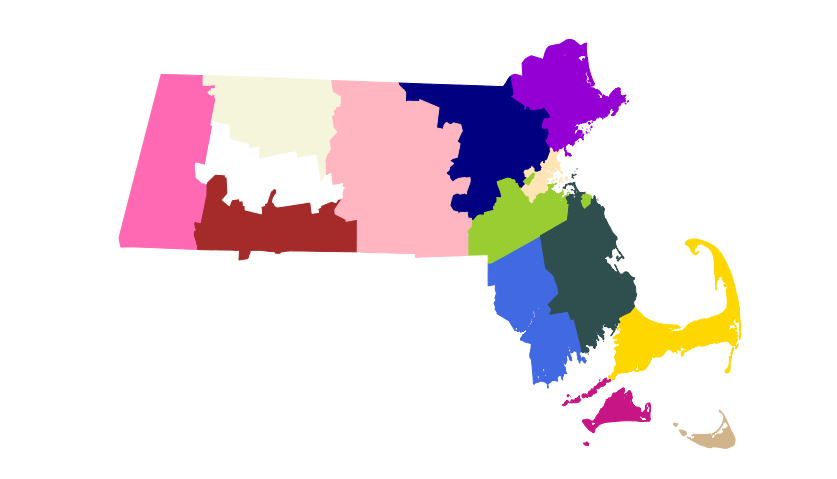

In [98]:
plt.figure()
counties = town_data['COUNTY'].unique()
colors = random.sample(list(mpl.colors.cnames),len(counties))
color_dict = dict(zip(counties, colors))

for row, shape in enumerate(town_data['geometry']):
    color = color_dict[town_data.ix[row,'COUNTY']]
    try:
        x,y = shape.exterior.coords.xy
    except:
        shape_list = list(shape)
        for sub_shape in shape_list:
            x,y = sub_shape.exterior.coords.xy
            plt.fill(x,y,color=color)
            
    plt.fill(x,y,color=color)
plt.gcf().set_size_inches(14,8)
plt.axis('off')
plt.show()

In [4]:
def get_nearby_town_info(town_data):
    # Adds capacity and count of centers in nearby towns using neighbor calculation from pysal library
    num_centers = []
    capacity = []
    w = ps.weights.user.queen_from_shapefile(SHAPE_FILE,idVariable=GEO_COL)
    for town_id in town_data.index:

        neighbors = w.neighbors[town_id]

        # Get sum total of centers and capacity in neighboring towns
        capacity.append(int(town_data.ix[neighbors,['Capacity']].sum()))
        num_centers.append(int(town_data.ix[neighbors,['center_count']].sum()))
    
    town_data['nearby_capacity'] = capacity
    town_data['nearby_centers'] = num_centers
    
def build_points(filename,lat,long):
    '''
    Creates dataframe from file to join to shapefile
    '''
    point_df = pd.read_csv(filename)
    point_df = gpd.GeoDataFrame(point_df)
    #Add Points to df
    point_list = []
    for index, row in point_df.iterrows():
        point_list.append(geometry.Point(row[long],row[lat]))
    point_df[GEOMETRY] = point_list
    return point_df

def point_out_of_bounds(point_df, shape_df):
    '''
    Drops points that aren't in the bounded area or are Null
    '''
    minx, miny, maxx, maxy = shape_df.total_bounds
    #Drop Null & out of range points
    return point_df[(point_df[CHILD_LAT] > miny) & (point_df[CHILD_LAT] < maxy) & (point_df[CHILD_LONG] > minx) & (point_df[CHILD_LONG] < maxx)] 
    
